<a href="https://colab.research.google.com/github/MatheoCruz/BLR_imputation_perovskite/blob/main/Evaluacion_imputacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROYECTO DE GRADO: ETAPA DE EVALUACION (Imputación)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTACION DE LIBRERIAS

In [ ]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from functools import partial
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from scipy import stats
import seaborn as sns
import pickle
import arviz as az

## FUNCIONES
- calculo_mape: Permite calcular la metrica de rendimiento mape
- parametros_rendimiento: Toma como variables de entrada las estimaciones y los valores de testeo para calcular el rendimeinto del modelo frente a distintas metricas, utilizando como valor frecuentista estimado la condicion de medicion.

In [ ]:
#---------------------------------FUNCIONES-------------------------------------
#Funcion para calcular el MAPE
def calculo_mape(y_true, y_pred):
  mask = (y_true != 0)
  y_true_masked = y_true[mask]
  y_pred_masked = y_pred[mask]
  absolute_errors = np.abs(y_true_masked - y_pred_masked)
  percentage_errors = absolute_errors / y_true_masked
  mape = np.mean(percentage_errors) * 100
  return mape
#-------------------------------------------------------------------------------
# Funcion para calcular parametros de rendimiento a partir de un parametro de medicion
def parametros_rendimiento(y_pred, y_true, medicion):
    # Calcular las métricas de rendimiento
    if medicion == "mean":
      y_pred = np.mean(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la media de la prediccion")
    elif medicion == "mode":
      y_pred = stats.mode(y_pred, axis = 1)[0]
      print("Parametros de rendimiento respecto a la moda de la prediccion")
    elif medicion == "median":
      y_pred = np.median(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la mediana de la prediccion")
    else:
      print("Opcion default, Parametros de rendimiento respecto la media de la prediccion")
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_ = calculo_mape(y_true, y_pred)
    print("mse = ", mse)
    print("mae = ", mae)
    print("r2 = ", r2)
    print("mape = ", mape_)
    return mse, mae, r2, mape_
#-------------------------------------------------------------------------------

## CARGA DE ARCHIVOS

Se carga el archivo que contiene los trazos generados por la etapa de entrenamiento o inferencia bayesiana, ademas de datos de entrenamiento y testeo segmentados.

In [ ]:
#Descarga de los archivos que contienen los modelos inferidos y los datos asociados de entrenamiento y testeo
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG/'
with open(ruta_drive + 'trazados.pkl', 'rb') as f:
    trazados_cargados = pickle.load(f)
with open(ruta_drive + 'data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open(ruta_drive + 'data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/datos_sintesis.csv")

## ESTIMACIONES Y PARAMETROS DE RENDIMIENTO.
Para este proceso se tiene en cuenta las siguientes etapas.
- Cargado de datos:

 En esta etapa se cargan los metadatos del modelo y las variables de testeo asi como tambien los metadatos de los datos de entrenamiento.
- Estimacion:
  
  Se genera la estimacion por medio de la regresin lineal que entrega como resultado una funcion de densidad de probabilidad.

- Comparativa frecuentista:

  Inicialmente se genera la estimacion frecuentista que esta dada por la media de la PDF estimada. Esta es comparando con el dato de testeo, por medio de los parametros de rendimientos.

- Evaluacion:
  Utilizando la funcion de parametros de rendimiento anteriormente mencionada se realiza la evaluacion frecuentista del modelo y de sus resultados obtenidos



In [ ]:
#-----------------Definicion de los parametros de la inferencia----------------
draws = 1000
tune = 500
chains = 5
#------------------------------------------------------------------------------
#save de las predicciones y variables de rendimiento
prediccion_mean = {}
prediccion = {}
desviacion_std = {}
mape_dato = {}
r2_dato = {}
for datos in data[data.columns[3:]]: # Se recorren todas las variables de interes
  names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness', "PCE", "Voc", "Jsc", "FF"]
  names.remove(datos)
  print(datos)
  #save temporal de las predicciones y variables de rendimiento para cada fold
  prediccion_mean_fold = {}
  prediccion_fold = {}
  desviacion_std_fold = {}
  mape_fold = []
  r2_fold = []
  for i in range(1,6): # Se recorre cada fold para cada variable de interes

#-----------------------------CARGA DE DATOS------------------------------------
    y_mean = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_mean'] #se carga la media de la salida
    y_std = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_std'] #se carga la std de la salida
    betas = [] #save para los betas generados en el sampleo
    print(f'fold#{i},{datos}')
    for name in names:
      betas.append(np.concatenate(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name]))
#-------------------------------------------------------------------------------
#------------------------------PREDICCION---------------------------------------
    y_pred = (np.asarray(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][f"Alpha_{datos}"]).reshape((draws*chains)) + np.dot(data_test[f'data_test_{datos}'][f'test_fold_{i}']['x_test'],np.asarray(betas))) # se genera la prediccion de la BLR
    y_pred=y_pred*(y_std) + y_mean # se remueve la normalizacion
    std = np.std(y_pred, axis = 1)
    #----------------VALOR FRECUENCTISTA DE LA PREDICCION-----------------------
    mean = np.mean(y_pred, axis = 1) # se calcula la media para la comparacion de resultados frecuentistas
    #---------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#-------------------------SAVE DE LAS PREDICCIONES------------------------------
    prediccion_mean_fold[f'fold_{i}'] = mean
    prediccion_fold[f'fold_{i}'] = y_pred
    desviacion_std_fold[f'fold_{i}'] = std
    print("Desviacion estandar: ", std)
    print("prediccion:", mean)
    print("y_test", data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#-------------------------------------------------------------------------------
#------------------------------EVALUACION---------------------------------------
    mse, mae, r2, mape = parametros_rendimiento(y_pred, data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'], "mean") # calculo de las metricas de rendimiento respecto a la media
    mape_fold.append(mape)
    r2_fold.append(r2)
#-------------------------------------------------------------------------------
#-----------SAVE DE RESULTADOS DE LAS PREDICCIONES Y EVALUACION-----------------
  mape_dato[f"{datos}"] = mape_fold
  r2_dato[f"{datos}"] = r2_fold
  prediccion_mean[f'prediccion_{datos}'] = prediccion_mean_fold
  prediccion[f'prediccion_{datos}'] = prediccion_fold
  desviacion_std[f'desviacion_std_{datos}'] = desviacion_std_fold
#-------------------------------------------------------------------------------

Band_gap
fold#1,Band_gap
Desviacion estandar:  [0.01445135 0.03070622 0.02233642 0.01956951 0.01363269 0.01380331
 0.01760176 0.01159963 0.01159963 0.01045319 0.01125185 0.02205334
 0.02230407]
prediccion: [1.51665755 1.55732369 1.49006912 1.50821171 1.57753424 1.56012163
 1.54440491 1.6205448  1.6205448  1.63092691 1.63175432 1.54906549
 1.54563179]
y_test [1.5  1.59 1.55 1.5  1.63 1.73 1.73 1.6  1.6  1.6  1.6  1.59 1.59]
Parametros de rendimiento respecto a la media de la prediccion
mse =  0.005962643901242538
mae =  0.054960708296375414
r2 =  -0.3482563812014847
mape =  3.322812082955614
fold#2,Band_gap
Desviacion estandar:  [0.01924235 0.01424804 0.01406096 0.01438914 0.01638156 0.018084
 0.01305152 0.02176366 0.01721696 0.01622741 0.02126704 0.02119439
 0.01721304]
prediccion: [1.49014506 1.5213068  1.5125103  1.49891346 1.50451975 1.48580822
 1.4996418  1.49112103 1.49080242 1.51187082 1.49573562 1.51689913
 1.52092249]
y_test [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]

## Metadatos del R2

In [ ]:
#Metadatos de los resultados de la prediccion obtenidos
for datos in data[data.columns[3:]]:
  print(datos)
  print(f'media = {np.mean(r2_dato[datos])}, std = {np.std(r2_dato[datos])}, min = {np.min(r2_dato[datos])}, max = {np.max(r2_dato[datos])}, mediana = {np.median(r2_dato[datos ])}')

Band_gap
media = -1.7681661256987689, std = 2.165113400943242, min = -5.304499876174245, max = 0.09855356441460594, mediana = -0.3482563812014847
DeltaH
media = -5.183301706356362, std = 5.450517636111425, min = -15.406126352138962, max = -0.4343842649716487, mediana = -3.98484308101318
DeltaL
media = -0.7048289692317649, std = 1.2415597178185087, min = -3.1853013373687817, max = 0.024376444911929473, mediana = -0.12360100792915962
Grain_size
media = -14.614213298567881, std = 27.638893944884334, min = -69.8751052347308, max = 0.43995018785528117, mediana = -1.2499517468441064
Thickness
media = -9.039178907347502, std = 11.058201981198783, min = -25.8472562422474, max = 0.4220840210787782, mediana = -0.7810747465266021
PCE
media = 0.6903293459744729, std = 0.5236765954515082, min = -0.35616073283356964, max = 0.980291860423973, mediana = 0.9448768288847639
Voc
media = 0.05299714745760984, std = 1.5136785573486844, min = -2.9727039036557037, max = 0.8725383857063481, mediana = 0.7630204

## Metadatos del MAPE

In [ ]:
for datos in data[data.columns[3:]]:
  print(datos)
  print(f'media = {np.mean(mape_dato[datos])}, std = {np.std(mape_dato[datos])}, min = {np.min(mape_dato[datos])}, max = {np.max(mape_dato[datos])}')

Band_gap
media = 6.363092148314107, std = 7.450118102990614, min = 0.696726606403294, max = 21.108605712503895
DeltaH
media = 73.67658711527125, std = 35.03119617640362, min = 14.364014207086177, max = 110.51980817095202
DeltaL
media = 138.71774250617287, std = 107.68386962773425, min = 24.99022592307172, max = 303.74380194149404
Grain_size
media = 142.2272588835159, std = 87.58793591145698, min = 76.04586068373577, max = 313.64061126573426
Thickness
media = 55.94823374469278, std = 32.29241279321399, min = 24.72096294636302, max = 99.25151575508166
PCE
media = 11.495364454259445, std = 13.536226053866002, min = 1.923555837381968, max = 37.02780624244157
Voc
media = 2.92963747366269, std = 1.5061728204298277, min = 1.4009729593181501, max = 5.7055743223140185
Jsc
media = 10.76590644540278, std = 11.615954695704854, min = 1.277647274209711, max = 30.491488320317732
FF
media = 4.296387868977344, std = 2.0279768764928736, min = 1.6750852717018614, max = 7.666134762712849


##Grafica de la PDF de las predicciones

In [ ]:
# PDF de las predicciones (ejemplo)
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
unidades = {"Band_gap": "eV", "DeltaH": "eV", "DeltaL": "eV", "Grain_size": "mm", "Thickness": "mm", "PCE": "%", "Voc": "V", "Jsc": "mA/cm^2", "FF": "%"}
for datos in data[data.columns[3:]]:
  print(datos)
  for i in range(1,6):
    predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    test = (data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    print(f'{i}-fold')
    for j in range(0,len(predicciones)):
      print(j)
      plt.figure(figsize=(8, 5))
      posterior_predictive = sns.kdeplot(predicciones[j], label = f'PDF posterior {datos}', color = "gray")
      plt.axvline(x=test[j], color='b', linestyle='--', linewidth=2, label='Valor Test', alpha = 0.6)
      # Calcular la media de la distribución de densidad posterior
      media_posterior = predicciones[j].mean()
      # Agregar línea vertical para la media de la distribución posterior
      plt.axvline(x=media_posterior, color='r', linestyle='--', linewidth=2, label='Media Posterior', alpha = 0.6)
      plt.xlabel(f"{datos}[{unidades[datos]}]")
      plt.ylabel("Densidad")
      plt.title("PDF")
      plt.legend()
      plt.grid(True, **grid_style)
      plt.show()

## Graficos de intervalo de credibilidad del 90%

Band_gap
Intervalo de confianza al 0.90: (1.49, 1.64)
min = [1.3883616341109586], max = [1.6849857517367286]
Valor porcentual HDI frente a la PDF =  50.69087831428594
Intervalo de confianza al 0.90: (1.47, 1.54)
min = [1.3883616341109586, 1.3997451704106718], max = [1.6849857517367286, 1.5974786774654497]
Valor porcentual HDI frente a la PDF =  35.20592283274018
Intervalo de confianza al 0.90: (1.47, 1.69)
min = [1.3883616341109586, 1.3997451704106718, 1.3315196394986135], max = [1.6849857517367286, 1.5974786774654497, 1.99645630406972]
Valor porcentual HDI frente a la PDF =  32.11153562988239
Intervalo de confianza al 0.90: (1.48, 1.68)
min = [1.3883616341109586, 1.3997451704106718, 1.3315196394986135, 1.3046299019910266], max = [1.6849857517367286, 1.5974786774654497, 1.99645630406972, 1.7501242179894927]
Valor porcentual HDI frente a la PDF =  43.472348924628285
Intervalo de confianza al 0.90: (0.60, 1.74)
min = [1.3883616341109586, 1.3997451704106718, 1.3315196394986135, 1.30462990

<Figure size 800x500 with 0 Axes>

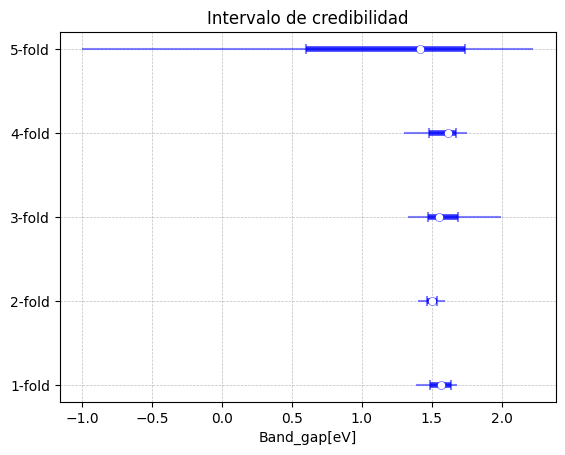

DeltaH
Intervalo de confianza al 0.90: (0.08, 0.45)
min = [-0.09129225713763206], max = [0.6941080829702102]
Valor porcentual HDI frente a la PDF =  46.80925273998696
Intervalo de confianza al 0.90: (0.08, 0.26)
min = [-0.09129225713763206, -0.09397196909304195], max = [0.6941080829702102, 0.39192222637894586]
Valor porcentual HDI frente a la PDF =  37.45972276515264
Intervalo de confianza al 0.90: (0.01, 0.88)
min = [-0.09129225713763206, -0.09397196909304195, -0.18778727891149977], max = [0.6941080829702102, 0.39192222637894586, 1.367258706216843]
Valor porcentual HDI frente a la PDF =  55.6555334069076
Intervalo de confianza al 0.90: (0.10, 0.45)
min = [-0.09129225713763206, -0.09397196909304195, -0.18778727891149977, -0.08284228667303217], max = [0.6941080829702102, 0.39192222637894586, 1.367258706216843, 0.7752130688048302]
Valor porcentual HDI frente a la PDF =  40.05766352620347
Intervalo de confianza al 0.90: (-0.50, 2.23)
min = [-0.09129225713763206, -0.09397196909304195, -0.1

<Figure size 800x500 with 0 Axes>

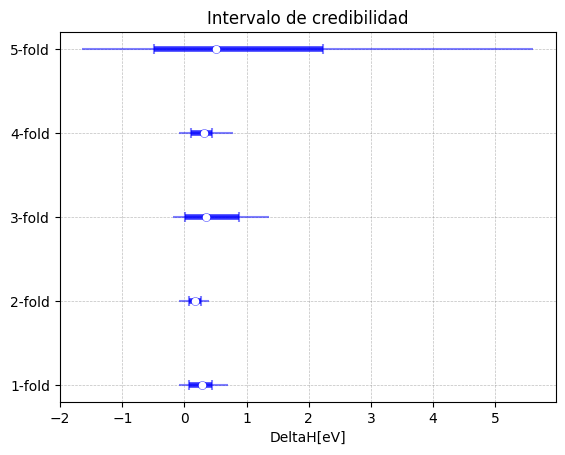

DeltaL
Intervalo de confianza al 0.90: (0.04, 0.40)
min = [-0.25145594853135794], max = [0.6588641722169863]
Valor porcentual HDI frente a la PDF =  38.718433608213864
Intervalo de confianza al 0.90: (0.10, 0.26)
min = [-0.25145594853135794, -0.11938042245481545], max = [0.6588641722169863, 0.38090128201477824]
Valor porcentual HDI frente a la PDF =  32.26361466767782
Intervalo de confianza al 0.90: (0.05, 0.56)
min = [-0.25145594853135794, -0.11938042245481545, -0.1579708147482546], max = [0.6588641722169863, 0.38090128201477824, 1.0634863301947792]
Valor porcentual HDI frente a la PDF =  42.153892097450374
Intervalo de confianza al 0.90: (0.19, 0.37)
min = [-0.25145594853135794, -0.11938042245481545, -0.1579708147482546, -0.19414332460847608], max = [0.6588641722169863, 0.38090128201477824, 1.0634863301947792, 0.6179395998140575]
Valor porcentual HDI frente a la PDF =  23.156545686599376
Intervalo de confianza al 0.90: (-0.17, 1.09)
min = [-0.25145594853135794, -0.11938042245481545, 

<Figure size 800x500 with 0 Axes>

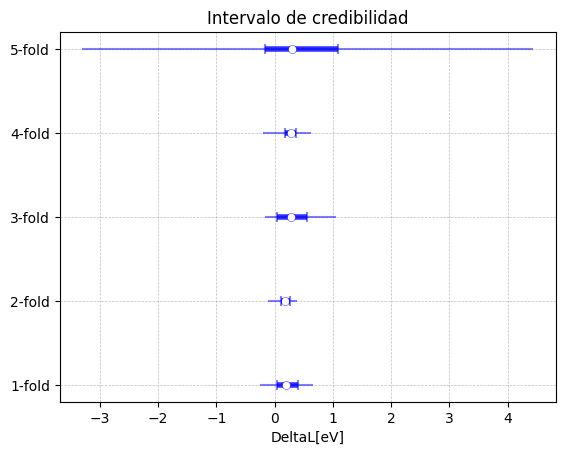

Grain_size
Intervalo de confianza al 0.90: (0.16, 1.23)
min = [-0.6893039873879929], max = [1.9113037309319307]
Valor porcentual HDI frente a la PDF =  40.95824008740618
Intervalo de confianza al 0.90: (0.50, 1.22)
min = [-0.6893039873879929, 0.06746533052376613], max = [1.9113037309319307, 1.7863295702724842]
Valor porcentual HDI frente a la PDF =  41.67714310476057
Intervalo de confianza al 0.90: (-1.37, 1.27)
min = [-0.6893039873879929, 0.06746533052376613, -2.9641876433915595], max = [1.9113037309319307, 1.7863295702724842, 2.2148610136696543]
Valor porcentual HDI frente a la PDF =  50.93171485163758
Intervalo de confianza al 0.90: (-0.63, 0.84)
min = [-0.6893039873879929, 0.06746533052376613, -2.9641876433915595, -2.762146613775347], max = [1.9113037309319307, 1.7863295702724842, 2.2148610136696543, 1.7841579030110246]
Valor porcentual HDI frente a la PDF =  32.2170783530661
Intervalo de confianza al 0.90: (-1.79, 2.39)
min = [-0.6893039873879929, 0.06746533052376613, -2.964187643

<Figure size 800x500 with 0 Axes>

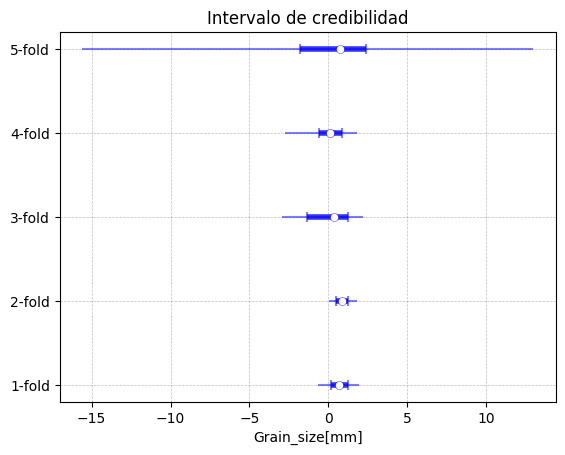

Thickness
Intervalo de confianza al 0.90: (0.30, 0.58)
min = [-0.0882930763514706], max = [0.9915915235416503]
Valor porcentual HDI frente a la PDF =  25.644260515459216
Intervalo de confianza al 0.90: (0.31, 0.60)
min = [-0.0882930763514706, 0.1297570553210775], max = [0.9915915235416503, 0.8272507389568855]
Valor porcentual HDI frente a la PDF =  40.64702691596868
Intervalo de confianza al 0.90: (0.04, 0.52)
min = [-0.0882930763514706, 0.1297570553210775, -0.524410646100123], max = [0.9915915235416503, 0.8272507389568855, 0.8542752249639094]
Valor porcentual HDI frente a la PDF =  35.37802207468041
Intervalo de confianza al 0.90: (-0.10, 0.69)
min = [-0.0882930763514706, 0.1297570553210775, -0.524410646100123, -0.7517395895607635], max = [0.9915915235416503, 0.8272507389568855, 0.8542752249639094, 0.9491050169154178]
Valor porcentual HDI frente a la PDF =  46.25831379586363
Intervalo de confianza al 0.90: (-1.42, 1.10)
min = [-0.0882930763514706, 0.1297570553210775, -0.52441064610012

<Figure size 800x500 with 0 Axes>

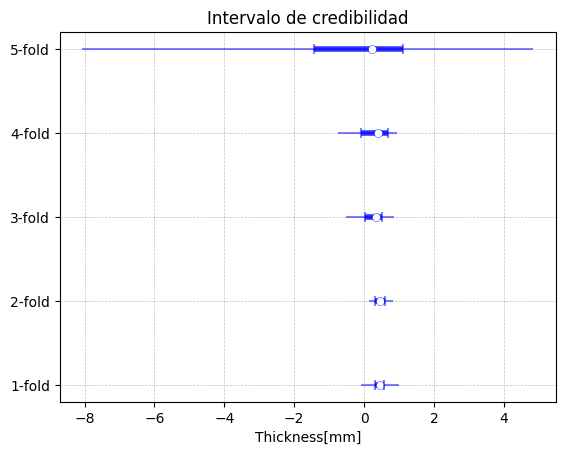

PCE
Intervalo de confianza al 0.90: (11.78, 20.09)
min = [9.597119051104283], max = [21.55483271202639]
Valor porcentual HDI frente a la PDF =  69.46278011970023
Intervalo de confianza al 0.90: (12.52, 18.45)
min = [9.597119051104283, 11.81704177831467], max = [21.55483271202639, 19.157270980234657]
Valor porcentual HDI frente a la PDF =  80.84461770941085
Intervalo de confianza al 0.90: (0.90, 20.37)
min = [9.597119051104283, 11.81704177831467, -2.9535212627350447], max = [21.55483271202639, 19.157270980234657, 21.432966555089102]
Valor porcentual HDI frente a la PDF =  79.82158424507409
Intervalo de confianza al 0.90: (12.26, 20.69)
min = [9.597119051104283, 11.81704177831467, -2.9535212627350447, 9.89002381846139], max = [21.55483271202639, 19.157270980234657, 21.432966555089102, 22.35077219754365]
Valor porcentual HDI frente a la PDF =  67.66166958805634
Intervalo de confianza al 0.90: (-9.93, 20.29)
min = [9.597119051104283, 11.81704177831467, -2.9535212627350447, 9.89002381846139

<Figure size 800x500 with 0 Axes>

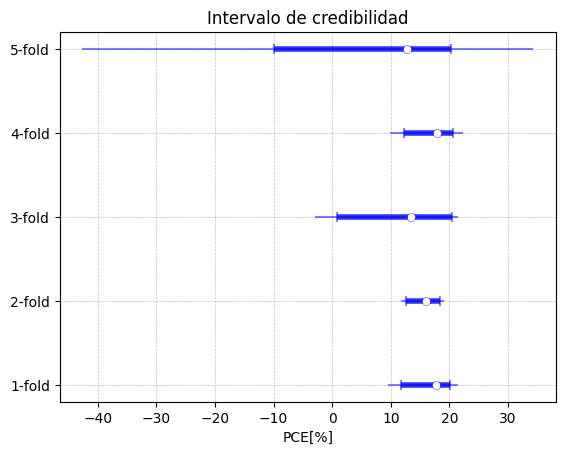

Voc
Intervalo de confianza al 0.90: (0.96, 1.18)
min = [0.8726224983420925], max = [1.2515140531963997]
Valor porcentual HDI frente a la PDF =  55.96551328504395
Intervalo de confianza al 0.90: (0.95, 1.13)
min = [0.8726224983420925, 0.8962962281504285], max = [1.2515140531963997, 1.194890304500694]
Valor porcentual HDI frente a la PDF =  58.3394395789883
Intervalo de confianza al 0.90: (0.85, 1.15)
min = [0.8726224983420925, 0.8962962281504285, 0.750361567145185], max = [1.2515140531963997, 1.194890304500694, 1.2564571766998023]
Valor porcentual HDI frente a la PDF =  58.32614411416942
Intervalo de confianza al 0.90: (0.96, 1.16)
min = [0.8726224983420925, 0.8962962281504285, 0.750361567145185, 0.817111369347683], max = [1.2515140531963997, 1.194890304500694, 1.2564571766998023, 1.232644775077838]
Valor porcentual HDI frente a la PDF =  47.94051638352095
Intervalo de confianza al 0.90: (0.62, 1.26)
min = [0.8726224983420925, 0.8962962281504285, 0.750361567145185, 0.817111369347683, -0

<Figure size 800x500 with 0 Axes>

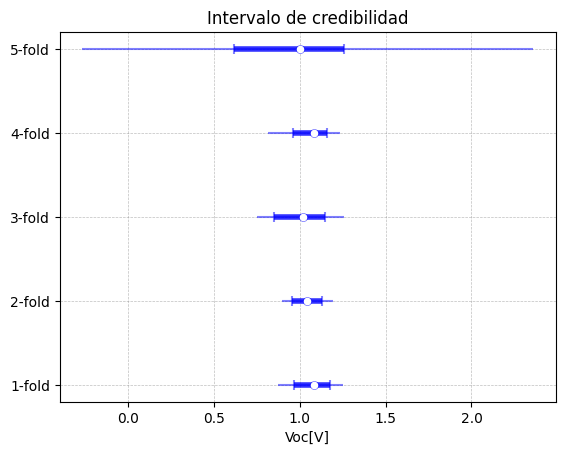

Jsc
Intervalo de confianza al 0.90: (18.08, 23.62)
min = [16.492898025165243], max = [24.988525426667785]
Valor porcentual HDI frente a la PDF =  65.13303182316076
Intervalo de confianza al 0.90: (18.77, 22.28)
min = [16.492898025165243, 18.063241737295193], max = [24.988525426667785, 23.13880612997963]
Valor porcentual HDI frente a la PDF =  69.09405568113914
Intervalo de confianza al 0.90: (-1.25, 22.95)
min = [16.492898025165243, 18.063241737295193, -4.720483001938973], max = [24.988525426667785, 23.13880612997963, 23.606267582014706]
Valor porcentual HDI frente a la PDF =  85.44313772864837
Intervalo de confianza al 0.90: (20.20, 24.18)
min = [16.492898025165243, 18.063241737295193, -4.720483001938973, 17.564459255624925], max = [24.988525426667785, 23.13880612997963, 23.606267582014706, 25.31603603972215]
Valor porcentual HDI frente a la PDF =  51.239481867946125
Intervalo de confianza al 0.90: (-9.06, 28.11)
min = [16.492898025165243, 18.063241737295193, -4.720483001938973, 17.56

<Figure size 800x500 with 0 Axes>

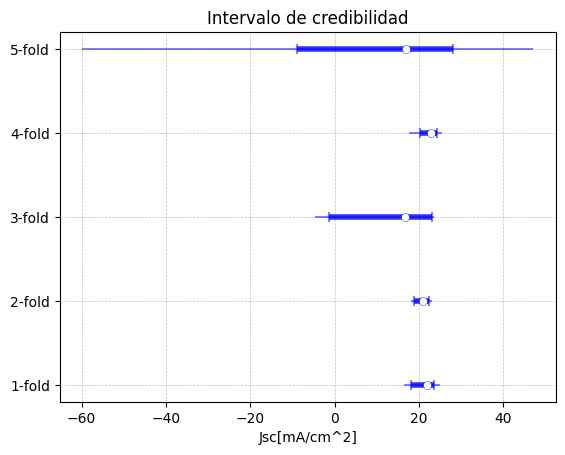

FF
Intervalo de confianza al 0.90: (0.68, 0.85)
min = [0.5837827459267195], max = [0.9553723474268128]
Valor porcentual HDI frente a la PDF =  44.31794635305223
Intervalo de confianza al 0.90: (0.67, 0.80)
min = [0.5837827459267195, 0.6365838263605507], max = [0.9553723474268128, 0.852868031220015]
Valor porcentual HDI frente a la PDF =  56.83247675187386
Intervalo de confianza al 0.90: (0.64, 0.83)
min = [0.5837827459267195, 0.6365838263605507, 0.4865824185789318], max = [0.9553723474268128, 0.852868031220015, 0.9226075014347749]
Valor porcentual HDI frente a la PDF =  41.58028923966983
Intervalo de confianza al 0.90: (0.65, 0.77)
min = [0.5837827459267195, 0.6365838263605507, 0.4865824185789318, 0.5614789997014041], max = [0.9553723474268128, 0.852868031220015, 0.9226075014347749, 0.8295882512166178]
Valor porcentual HDI frente a la PDF =  45.783449018487026
Intervalo de confianza al 0.90: (0.58, 1.04)
min = [0.5837827459267195, 0.6365838263605507, 0.4865824185789318, 0.5614789997014

<Figure size 800x500 with 0 Axes>

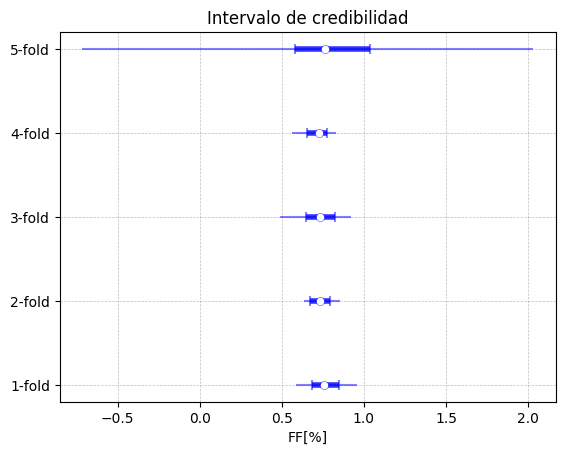

In [ ]:
alpha = 0.1
fold = ["1-fold", "2-fold", "3-fold", "4-fold", "5-fold"]
for datos in data[data.columns[3:]]:
  print(datos)
  ci_low = []
  ci_upper = []
  mean = []
  min = []
  max = []
  for i in range(1,6):
    lower_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], alpha/2 * 100)
    upper_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], (1 - alpha/2) * 100)
    min_ = np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    max_ = np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    min.append(np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    max.append(np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    ci_low.append(lower_bound)
    ci_upper.append(upper_bound)
    mean.append(np.mean(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    print(f"Intervalo de confianza al {1-alpha:.2f}: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"min = {min}, max = {max}")
    porcentaje_hdi = (upper_bound-lower_bound)/(max_-min_)*100
    print('Valor porcentual HDI frente a la PDF = ', porcentaje_hdi)
  # Crear un arreglo de posiciones para las barras horizontales
  positions = np.arange(len(fold))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()
  # Dibujar las barras horizontales principales
  ax.hlines(positions, min, max, colors='b', alpha=0.5, linewidth=1.5)
  # Dibujar las barras horizontales secundarias
  ax.hlines(positions, ci_low, ci_upper, colors='b', alpha=0.8, linewidth=4)

  # Dibujar los puntos de estimación puntual
  ax.scatter(mean, positions, color='blue', marker='o', s = 30, zorder=10, alpha = 0.5)
  ax.scatter(mean, positions, color='white', marker='o', s = 20, zorder=10, alpha = 1)
  ax.scatter(ci_low, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  ax.scatter(ci_upper, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_yticks(positions)
  ax.set_yticklabels(fold)
  ax.set_xlabel(f'{datos}[{unidades[datos]}]')
  #ax.set_ylabel('Parámetros')
  # Título del gráfico
  ax.set_title(f'Intervalo de credibilidad')
  # Mostrar el gráfico
  ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/HDI/'
  plt.grid(True, **grid_style)
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de relacion entre estimaciones y datos reales

Band_gap


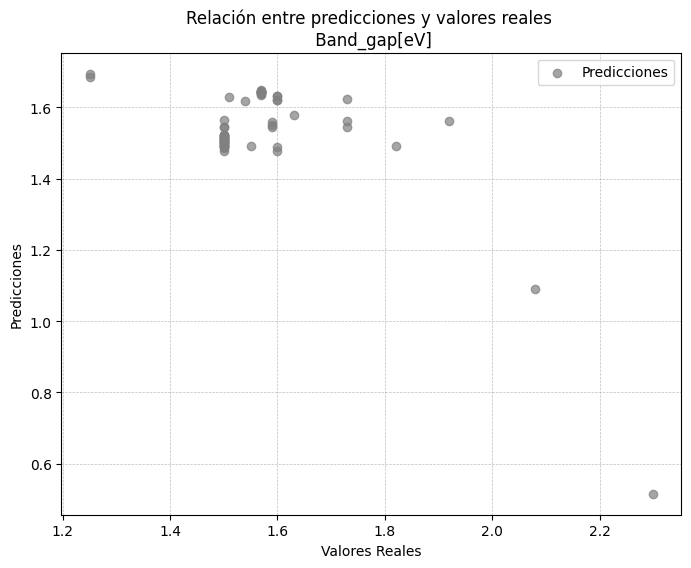

DeltaH


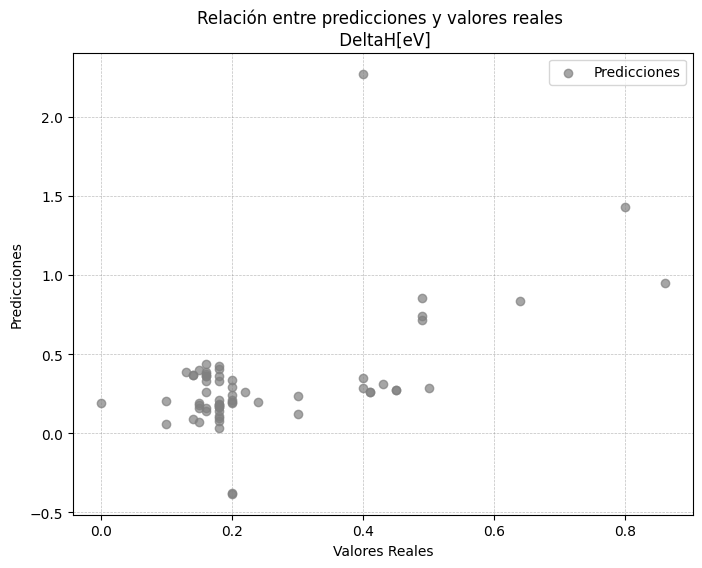

DeltaL


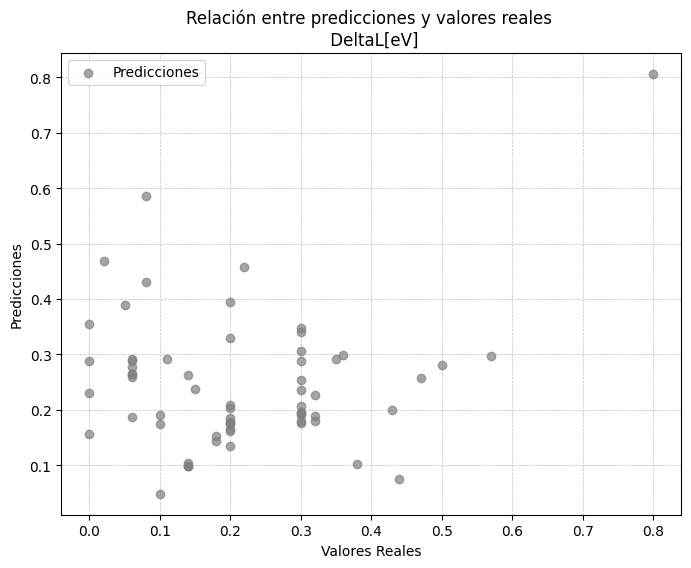

Grain_size


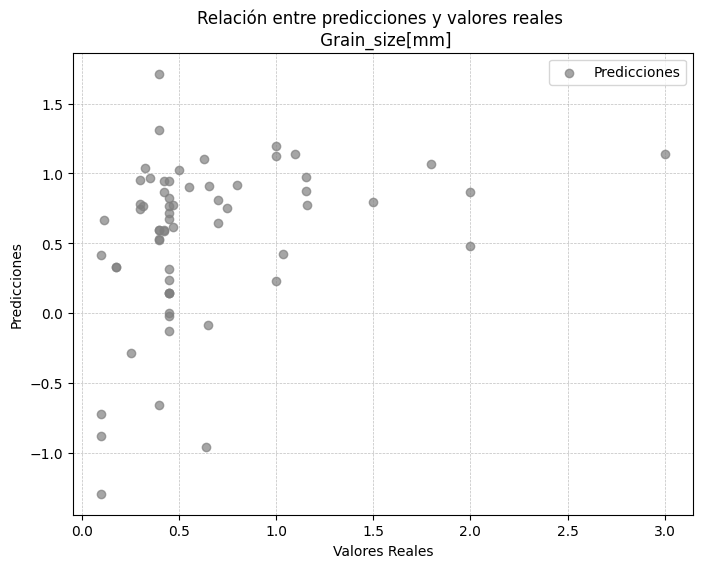

Thickness


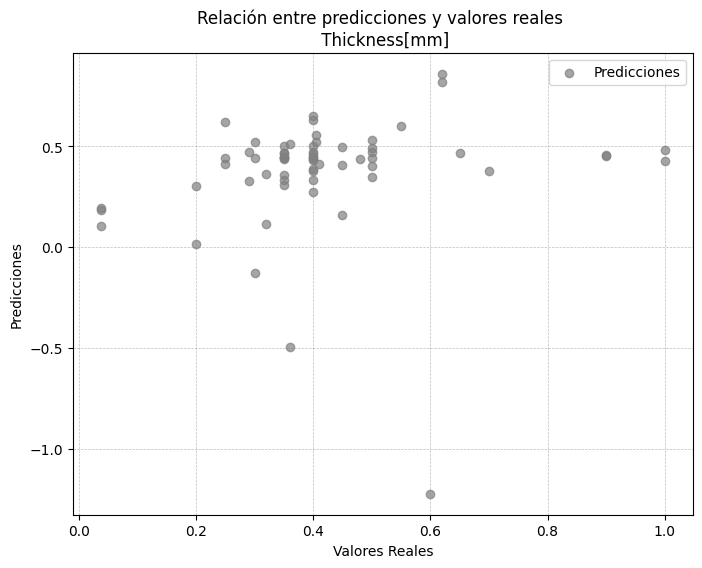

PCE


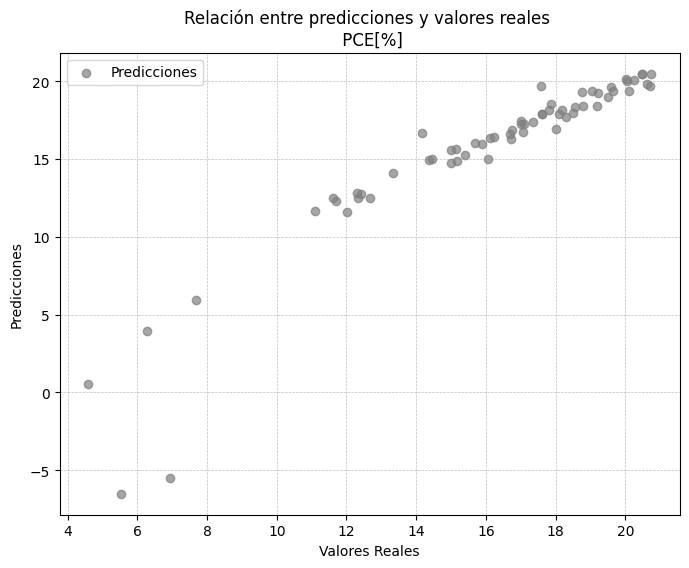

Voc


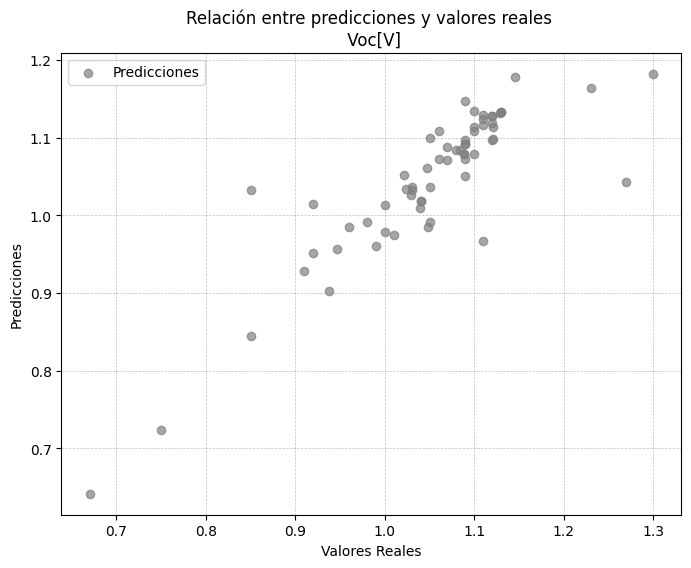

Jsc


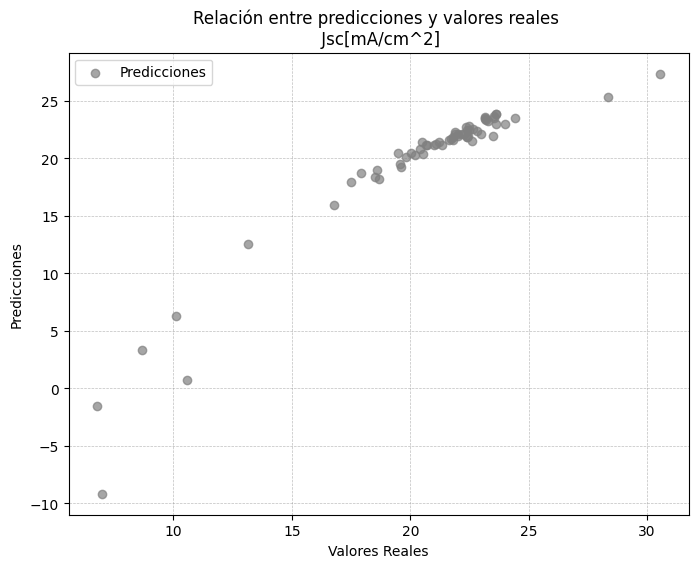

FF


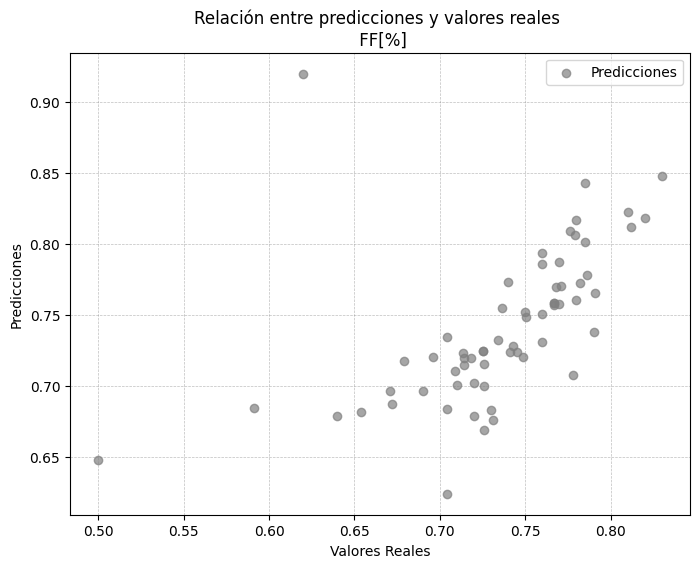

In [ ]:
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/CorrelacionPvR/'
for datos in data[data.columns[3:]]:
  print(datos)
  predicciones = []
  valor_real = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  valores_reales = np.concatenate(valor_real)
  plt.figure(figsize=(8, 6))
  plt.scatter(valores_reales, valores_predichos, label='Predicciones', color='gray', alpha = 0.7)
  plt.xlabel(f'Valores Reales')
  plt.ylabel('Predicciones')
  plt.title(f'Relación entre predicciones y valores reales \n {datos}[{unidades[datos]}]')
  plt.legend()
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.grid(True, **grid_style)
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de comparacion de estimaciones vs datos reales

Band_gap
[1.51665755 1.55732369 1.49006912 1.50821171 1.57753424 1.56012163
 1.54440491 1.6205448  1.6205448  1.63092691 1.63175432 1.54906549
 1.54563179]
[1.49014506 1.5213068  1.5125103  1.49891346 1.50451975 1.48580822
 1.4996418  1.49112103 1.49080242 1.51187082 1.49573562 1.51689913
 1.52092249]
[1.51911307 1.48986629 1.54470381 1.50033564 1.62331935 1.51500855
 1.61647071 1.64962683 1.62826812 1.50503175 1.56511882 1.51184835
 1.52207687]
[1.50572137 1.50204597 1.64394178 1.64394178 1.64258864 1.64108288
 1.64210362 1.64631441 1.63693102 1.63514924 1.64201629 1.64252461]
[1.48991649 1.51837225 1.54359705 1.68404622 1.47773425 1.08889684
 1.47857101 1.48832652 1.69394078 1.48755313 1.56087466 0.51596912]


<Figure size 800x500 with 0 Axes>

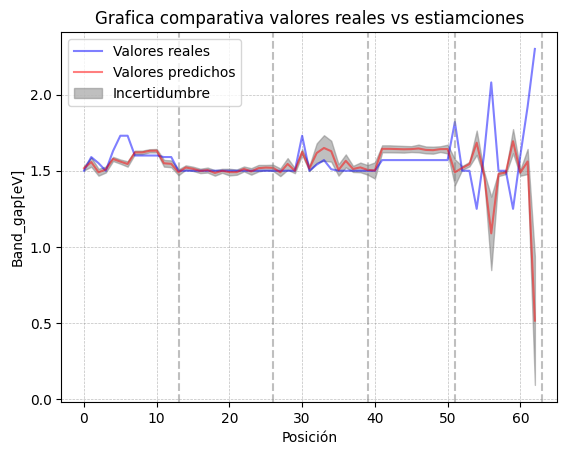

DeltaH
[0.07090218 0.28405765 0.20615584 0.35177234 0.25787332 0.36230436
 0.42481611 0.25759999 0.25759999 0.2741614  0.27283429 0.36208247
 0.36244365]
[0.21027182 0.1584107  0.16377804 0.18199368 0.18134304 0.13754429
 0.17851494 0.11084666 0.24307931 0.1970846  0.18902702 0.09904802
 0.16436386]
[0.32704623 0.03014021 0.44032615 0.0912696  0.3141158  0.07543719
 0.71389732 0.85607723 0.74094182 0.05808976 0.28618705 0.12246904
 0.40461004]
[0.18801992 0.3371358  0.36533491 0.36533491 0.37129781 0.38906177
 0.33097574 0.15692194 0.38771291 0.39840493 0.26213504 0.13831005]
[ 0.83426309  0.21061862  0.17819309 -0.38237467  0.29037701  1.43004197
  0.18828349  0.19709153 -0.37999062  0.23433547  0.94804829  2.2723089 ]


<Figure size 800x500 with 0 Axes>

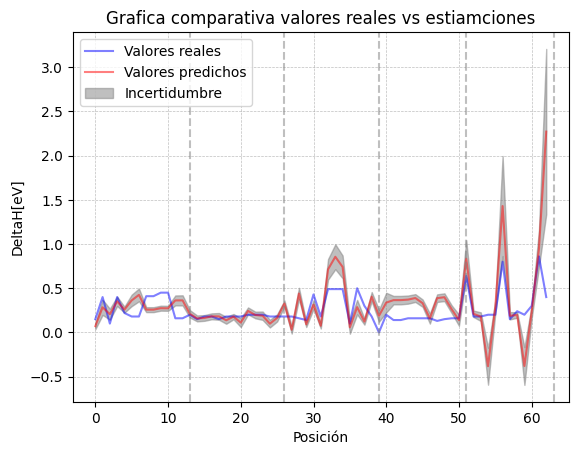

DeltaL
[0.17479003 0.23653646 0.25717864 0.20949332 0.15199445 0.18894202
 0.19894914 0.09778346 0.09778346 0.0978084  0.10336614 0.32951191
 0.3484549 ]
[0.19045588 0.25390749 0.20331701 0.16469624 0.17662721 0.13557937
 0.17890535 0.16113856 0.15608511 0.19398523 0.17597736 0.18052036
 0.1963435 ]
[0.2921371  0.10143802 0.4583552  0.20673455 0.14320712 0.18030007
 0.38839557 0.46798891 0.43135517 0.30621058 0.28886058 0.04862631
 0.39385115]
[0.34089127 0.23035674 0.26535839 0.26535839 0.26004152 0.27666329
 0.26376983 0.28066934 0.28841957 0.29108346 0.29916835 0.29682748]
[0.0751503  0.18473696 0.22736889 0.23841452 0.35513534 0.58632779
 0.19120715 0.17414121 0.29106817 0.28753631 0.18691606 0.80664632]


<Figure size 800x500 with 0 Axes>

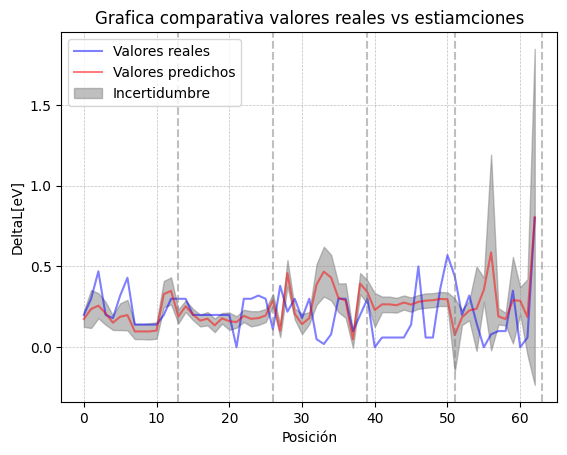

Grain_size
[0.87714612 1.14001653 1.06348778 0.41246592 0.64724593 0.80652301
 0.6651847  0.59675034 0.59675034 0.52423072 0.53162636 0.33061985
 0.33151102]
[0.77915356 0.97123279 0.91366658 0.90450394 0.74260735 0.95393595
 0.90864659 0.76443439 0.58395672 0.59454235 1.10437496 1.02102059
 1.1360582 ]
[ 0.42314262  1.04039312  0.47666697  0.76890814  1.12257758  1.19566011
 -0.71996983 -1.293973   -0.88356087  0.77230575  0.61927695  0.96856988
  0.23237207]
[-0.08448082 -0.66119916  0.14602239  0.14602239  0.14135437 -0.01908059
  0.23688885  0.71314076  0.00357484 -0.12695629  0.31514041  0.67038924]
[-0.28947619  0.79163259  0.86373136  0.94378866  1.30913074  0.7516177
  0.9467152   0.86322118  0.82404091  1.71341146  0.7709155  -0.95879842]


<Figure size 800x500 with 0 Axes>

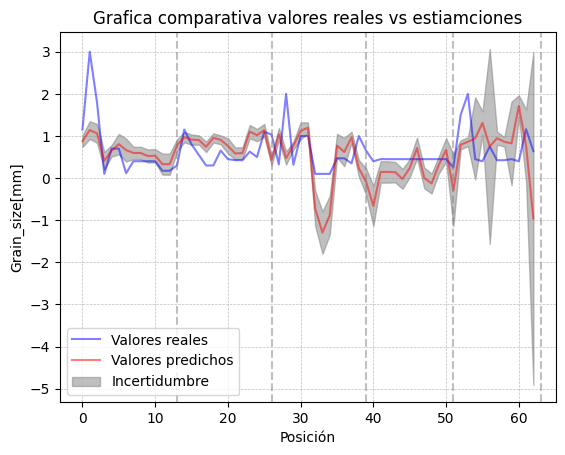

Thickness
[0.50896087 0.52907835 0.49530428 0.37789425 0.43052963 0.40291352
 0.34695965 0.46521062 0.46521062 0.43786497 0.4423835  0.45342562
 0.4543527 ]
[0.46265966 0.47031781 0.4886967  0.44304778 0.44541437 0.50166297
 0.44594188 0.41340464 0.33300995 0.35741107 0.51923239 0.59966968
 0.46954468]
[0.3275566  0.43983686 0.30227065 0.44272763 0.46468839 0.43645489
 0.19356989 0.10324627 0.18572127 0.4829872  0.42689407 0.40586313
 0.36018505]
[ 0.11383148 -0.12798539  0.44549149  0.44549149  0.43740338  0.37620225
  0.47118242  0.65131262  0.38806878  0.33073936  0.50065197  0.62963227]
[ 0.01279131  0.30730866  0.27452749  0.85862832  0.41247061 -0.49771602
  0.55287083  0.51805982  0.81946098  0.62071845  0.15866632 -1.22217113]


<Figure size 800x500 with 0 Axes>

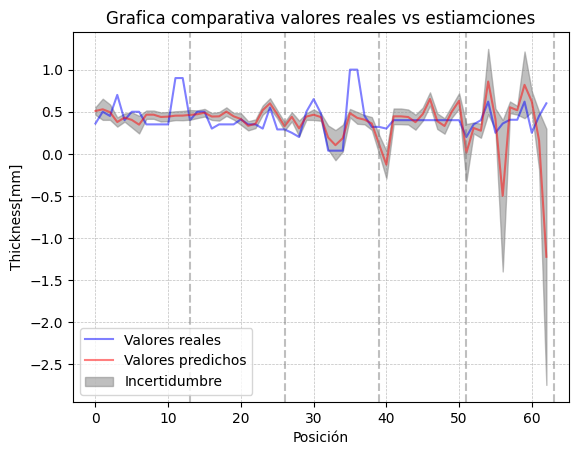

PCE
[19.70558252 19.38431609 16.89408885 11.64162523 19.78843904 17.96408305
 14.83746707 17.90709801 17.90709801 17.24623105 17.44494143 20.01666709
 19.24171439]
[12.81510058 17.91213244 18.31952953 16.01554274 16.38453836 15.96000871
 16.37453229 15.25993764 15.66601479 12.48944329 15.58091902 18.42095485
 17.38734547]
[14.91023279 14.75361614 14.06671517 16.57603002 20.45423247 18.95983238
  5.96608439  0.51107136  3.92897955 19.38654356 14.97778664 18.38004974
 12.51126318]
[12.76615472 12.2915927  20.47480527 20.47480527 20.13094791 19.38727296
 19.59501704 17.69917718 19.26877632 18.51828149 16.86155176 16.26736459]
[11.60089261 18.15172804 17.25222035 19.67128885 12.49064903 -6.51372616
 20.06062311 18.13901918 16.6720083  16.71670453 14.96340319 -5.49388301]


<Figure size 800x500 with 0 Axes>

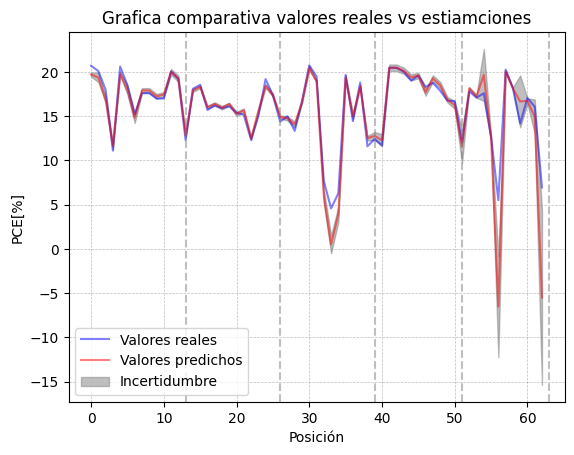

Voc
[1.12386682 1.03585856 1.01495369 0.95705096 1.17858069 1.09733758
 1.09992884 1.078473   1.078473   1.11311233 1.09881336 1.10821169
 1.11383516]
[0.95125685 1.07106492 1.08357563 1.03241684 1.09141244 1.01355132
 1.02670343 1.01810748 1.00997101 1.03338233 0.98446019 1.13454679
 1.07303977]
[0.96098832 1.05146981 0.90307373 1.06090906 1.13231087 1.12894541
 0.99207275 1.01891169 0.97510295 1.08453044 0.97918792 1.12765239
 0.84537639]
[0.98499221 0.96721136 1.13331106 1.13331106 1.11821018 1.09752545
 1.11607456 1.14673452 1.07207153 1.05062896 1.08746348 1.10826312]
[1.18225234 1.07942953 1.03707832 0.7238718  0.92819607 1.03207466
 1.12746532 1.0912964  0.64177922 0.9914043  1.16360425 1.04336147]


<Figure size 800x500 with 0 Axes>

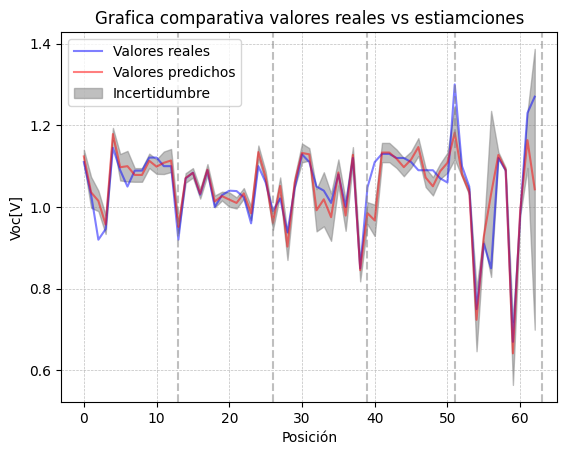

Jsc
[22.98774005 21.9758672  22.50373389 17.96042272 23.29480917 23.55231596
 21.39489656 21.86289957 21.86289957 21.14236216 21.14236216 23.30898955
 22.71859012]
[19.03036227 22.09614047 22.16736389 20.81458461 20.45871625 21.58797238
 21.26065223 22.15072745 21.14574721 18.74813926 20.16351954 21.9878748
 21.15865594]
[20.30008537 21.62894512 19.54347407 21.40778819 23.01207088 22.60809355
  6.31690085 -1.56349834  3.35809731 22.45304726 18.36660111 21.82932764
 18.20173242]
[20.50708818 20.42722779 23.86542655 23.86542655 23.7262922  23.50046088
 23.55752072 22.42873188 23.57270677 23.44394022 22.13516371 21.95653755]
[12.51803146 22.33039456 22.79175845 27.37737843 19.22896531  0.76397876
 22.16504326 21.69076472 25.34407117 21.48567752 15.96198046 -9.17270307]


<Figure size 800x500 with 0 Axes>

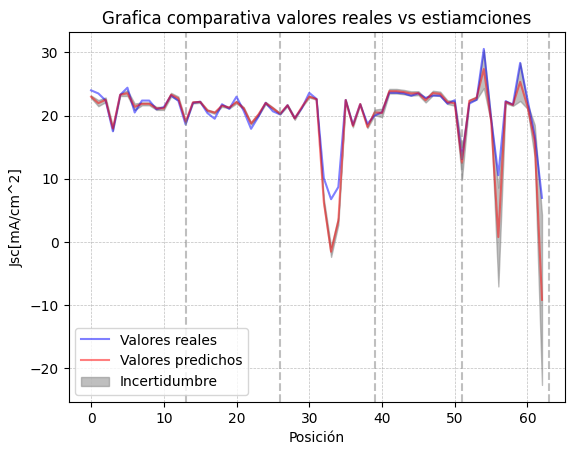

FF
[0.8168205  0.84795971 0.81844567 0.69595952 0.786047   0.72051548
 0.6960073  0.72472261 0.72472261 0.71917733 0.71472363 0.77825809
 0.77203538]
[0.7020763  0.76953452 0.76992809 0.72043908 0.73052771 0.71539387
 0.72375258 0.67888453 0.68337245 0.6868041  0.73765047 0.80105791
 0.76511712]
[0.67842584 0.71741425 0.66868446 0.75219819 0.80616916 0.80864958
 0.68277059 0.68130461 0.69989449 0.82214813 0.76050418 0.78719009
 0.67602505]
[0.68431842 0.64735734 0.75840522 0.75840522 0.7505987  0.7318201
 0.74803507 0.75476917 0.72789184 0.71025125 0.72311243 0.73409757]
[0.62380398 0.72347618 0.71936405 0.79383266 0.70070671 0.91986054
 0.81161504 0.75715004 0.7733695  0.75724825 0.70732761 0.84253622]


<Figure size 800x500 with 0 Axes>

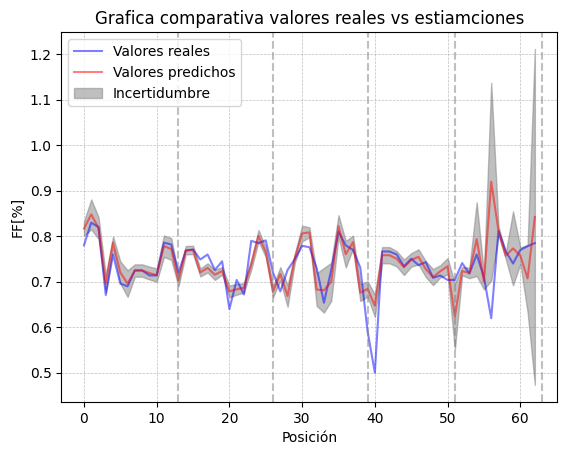

In [ ]:
# Especifica la ruta de la carpeta en Google Drive donde deseas guardar la imagen
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/Comportamiento_predicciones/'
for datos in data[data.columns[3:]]:
  print(datos)
  predicciones = []
  desviaciones_std = []
  valor_real = []
  posiciones = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    desviaciones_std.append(desviacion_std[f"desviacion_std_{datos}"][f"fold_{i}"])
    print(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    posiciones.append(len(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"]))
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  desviaciones_std = np.concatenate(desviaciones_std)
  valor_superior = np.array(valores_predichos) + np.array(desviaciones_std)
  valor_inferior = np.array(valores_predichos) - np.array(desviaciones_std)
  valores_reales = np.concatenate(valor_real)
  x = np.arange(len(valores_predichos))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()

  # Graficar los valores en función de las posiciones con colores diferentes
  ax.plot(x, valores_reales, color='blue', linestyle='-', label='Valores reales', alpha = 0.5)
  ax.plot(x, valores_predichos, color='red', linestyle='-', label='Valores predichos', alpha = 0.5)
  ax.fill_between(x, valor_superior, valor_inferior, color='gray', alpha=0.5, label='Incertidumbre')
  nueva_posicion = 0
  for posicion in posiciones:
    nueva_posicion = posicion + nueva_posicion
    ax.axvline(x=nueva_posicion, color='gray', linestyle='--', alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_xlabel('Posición')
  ax.set_ylabel(f'{datos}[{unidades[datos]}]')


  # Título de la gráfica
  ax.set_title(f'Grafica comparativa valores reales vs estiamciones')
  # Leyenda
  ax.legend()
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  # Mostrar la gráfica
  plt.show()

## Grafico de densidad conjunta de las predicciones vs los datos reales

In [ ]:
#for datos in data[data.columns[3:]]:
#  print(datos)
#  predicciones = []
#  valor_real = []
#  for i in range(1,6):
#    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
#    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#  valores_predichos = np.concatenate(predicciones)
#  valores_reales = np.concatenate(valor_real)
#  # Crear un DataFrame con los datos
#  df_data = pd.DataFrame({'Valores Predichos': valores_predichos, 'Valores Reales': valores_reales})
#
#  # Crear el gráfico de densidad conjunta
#  sns.jointplot(data=df_data, x='Valores Predichos', y='Valores Reales', kind='kde')
#  #plt.title(f"Grafico de densidad conjunta para {datos}")
#  # Mostrar el gráfico
#  plt.show()
#

## Densidad posterior predictiva

Band_gap


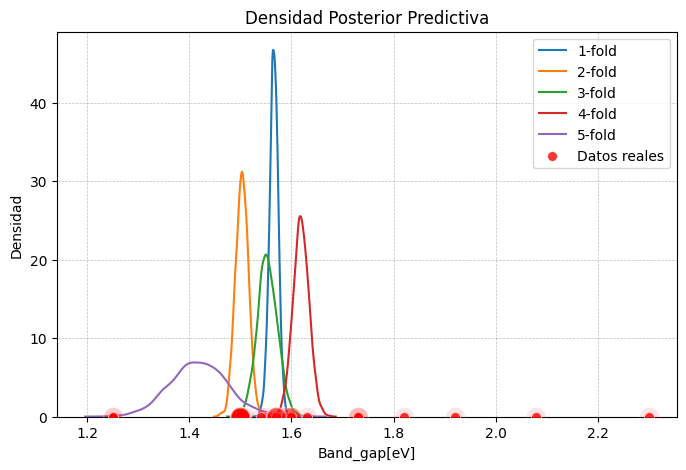

DeltaH


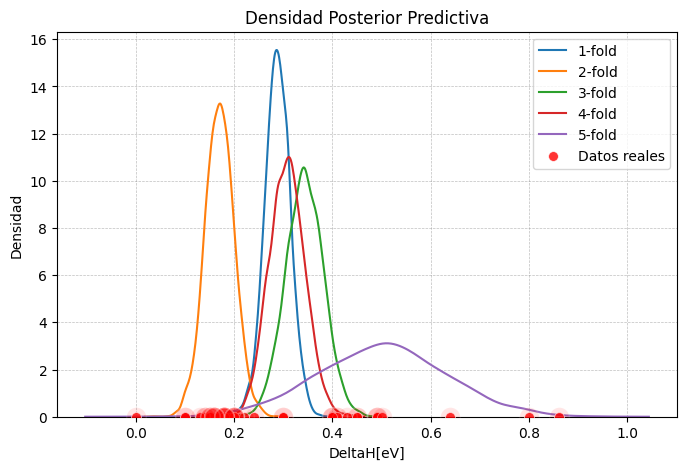

DeltaL


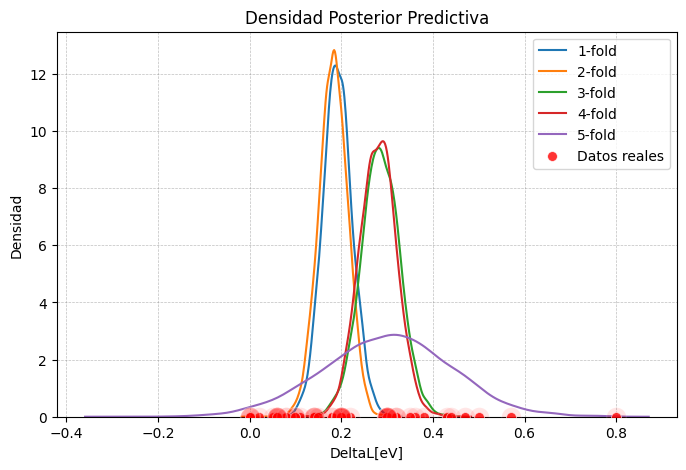

Grain_size


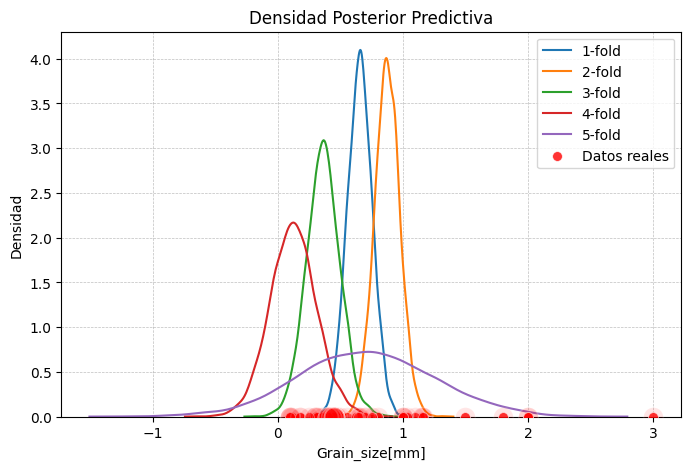

Thickness


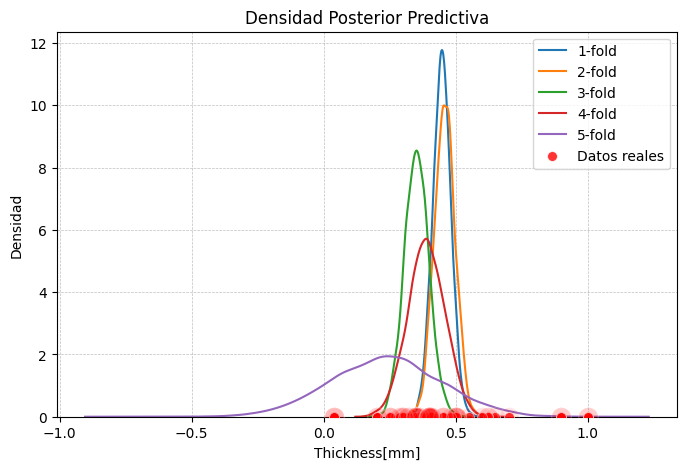

PCE


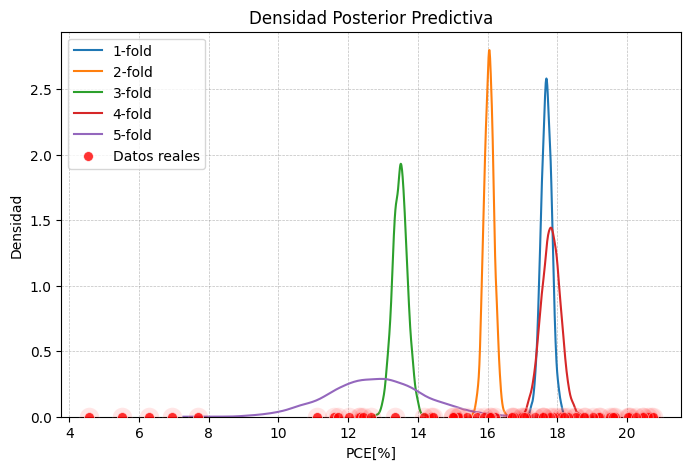

Voc


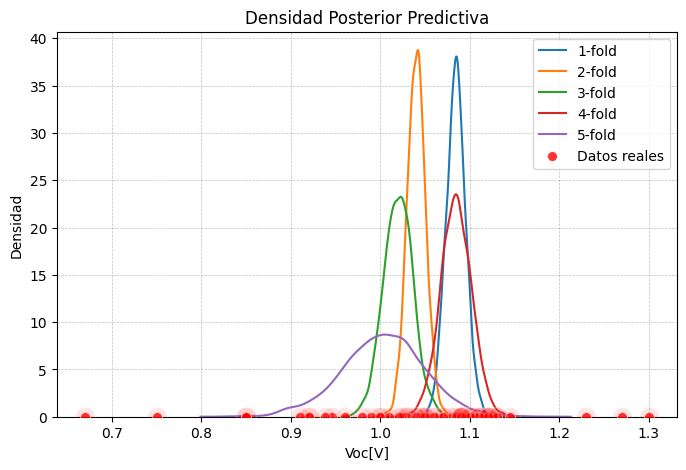

Jsc


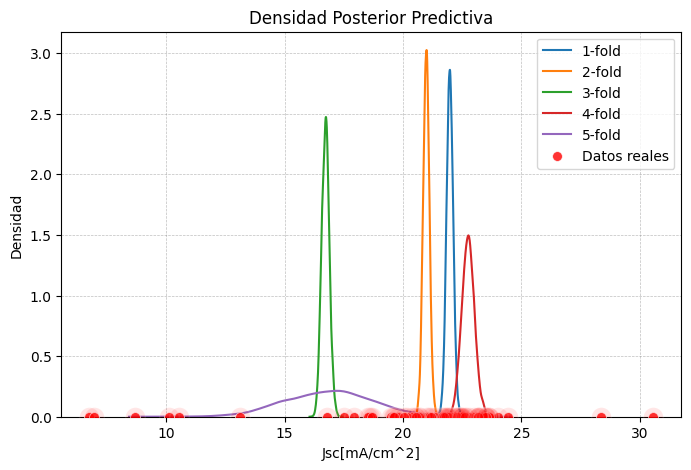

FF


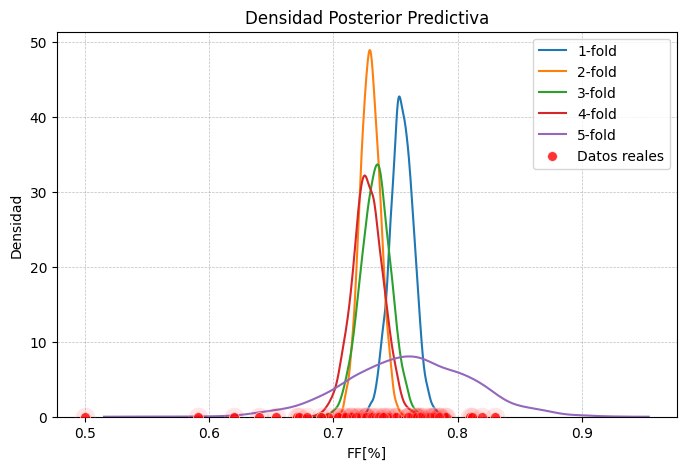

In [ ]:
# PDF de las predicciones (ejemplo)
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/DPP/'
for datos in data[data.columns[3:]]:
  print(datos)
  densidad_predicciones = []
  test = []
  predicciones_ = []
  for i in range(1,6):
    pdf_predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    densidad_prediccion = np.mean([pdf_predicciones[j] for j in range(len(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test']))], axis=0)
    densidad_predicciones.append(densidad_prediccion)
    test.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    predicciones_.append(pdf_predicciones)
  test = np.concatenate(test)
  densidad_predicciones = np.asarray(densidad_predicciones)
  # Crear el gráfico
  plt.figure(figsize=(8, 5))
  # Histograma de los datos de prueba
  for i in range(0,5):
    posterior_predictive = sns.kdeplot(densidad_predicciones[i], label = f'{i+1}-fold')
  sns.scatterplot(x=test, y=np.zeros_like(test), color='red', marker='o',s = 50, zorder=10, alpha = 0.8, label = "Datos reales")
  sns.scatterplot(x=test, y=np.zeros_like(test), color='r', marker='o',s = 200, alpha = 0.1, zorder=10)
  plt.xlabel(f"{datos}[{unidades[datos]}]")
  plt.ylabel('Densidad')
  plt.title(f'Densidad Posterior Predictiva')
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  plt.show()


##Grafico del trazado para cada variable y cada modelo generado

In [ ]:
#for datos in data[data.columns[8:9]]:
#  print(datos)
#  for i in range(1,6):
#    idata = az.convert_to_inference_data(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'])
#    print(datos, f'fold#{i}')
#    az.plot_trace(idata, var_names = ['A', "B", "X", "Band_gap"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["DeltaH", "DeltaL",'Grain_size', "Thickness"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["PCE", "Voc", "Jsc", "FF"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    plt.show()

<Figure size 800x500 with 0 Axes>

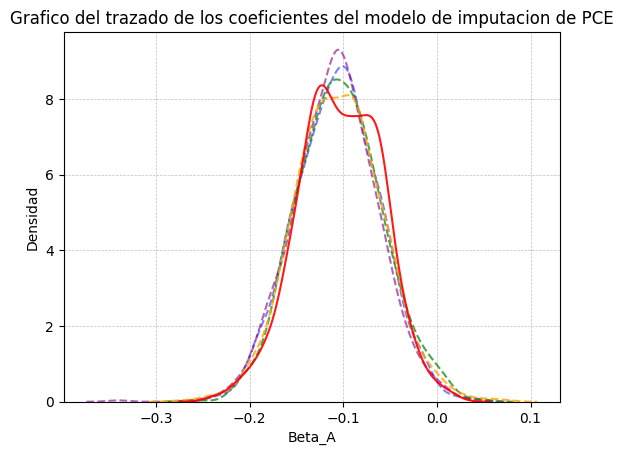

<Figure size 800x500 with 0 Axes>

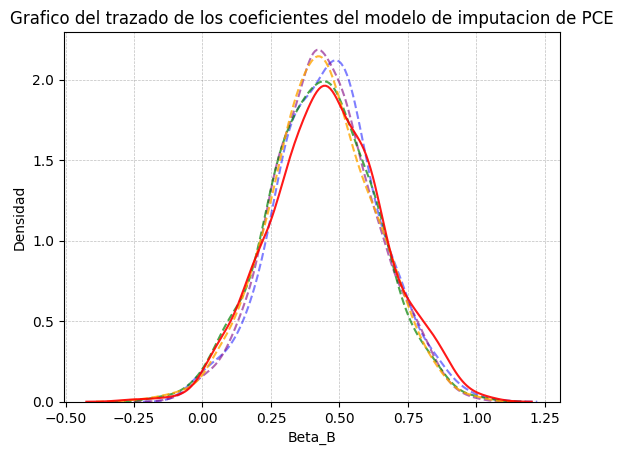

<Figure size 800x500 with 0 Axes>

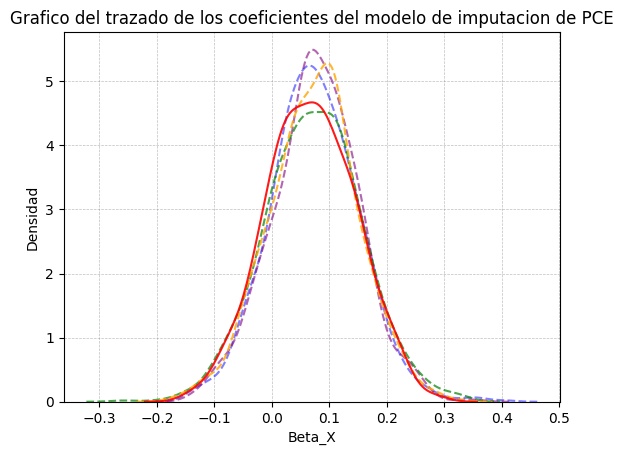

<Figure size 800x500 with 0 Axes>

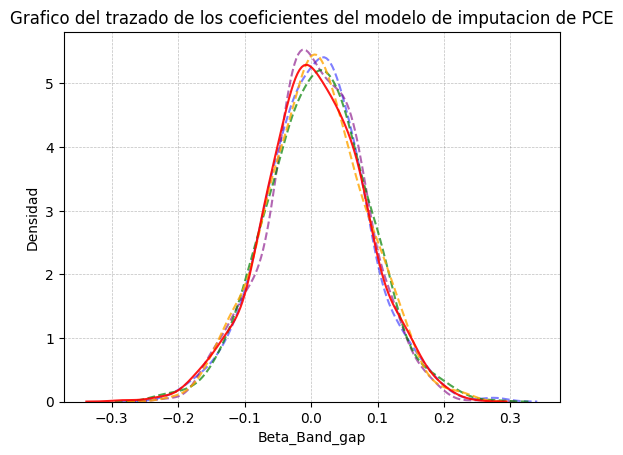

<Figure size 800x500 with 0 Axes>

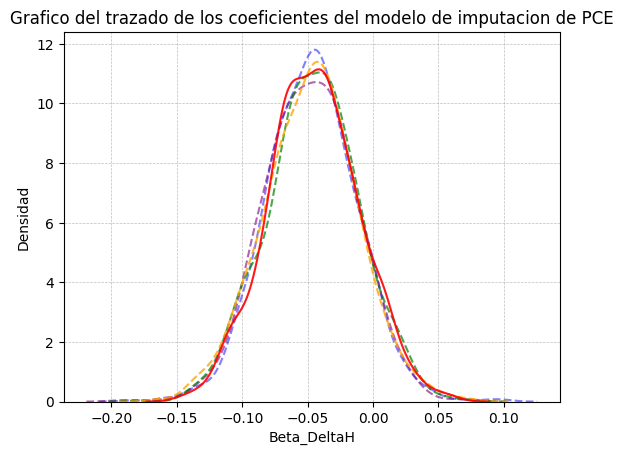

<Figure size 800x500 with 0 Axes>

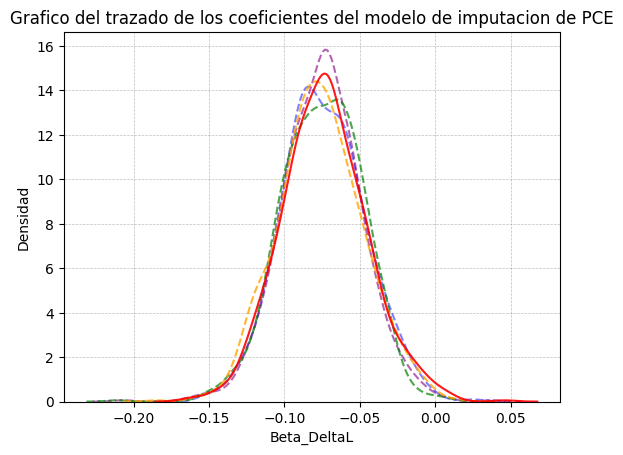

<Figure size 800x500 with 0 Axes>

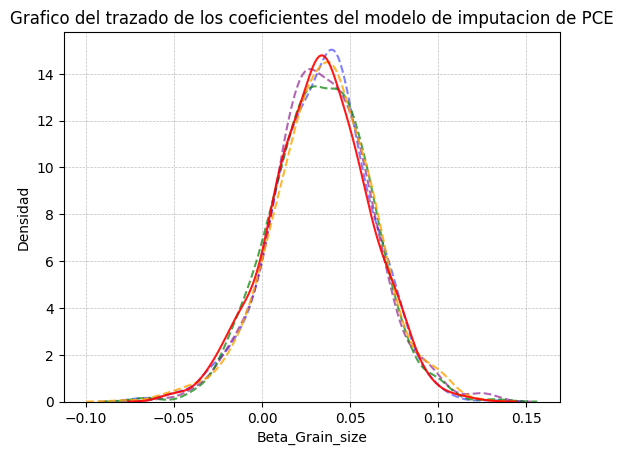

<Figure size 800x500 with 0 Axes>

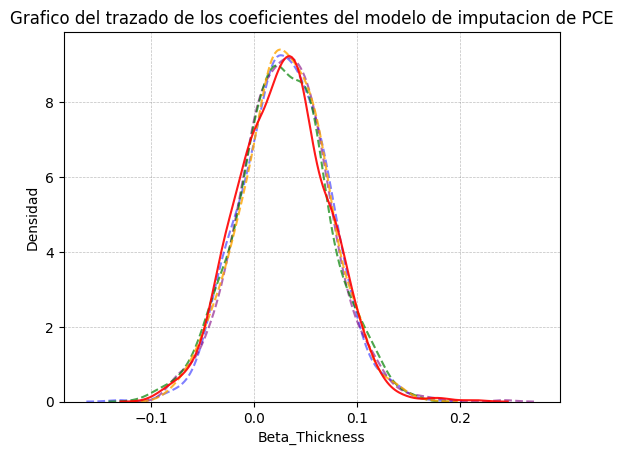

<Figure size 800x500 with 0 Axes>

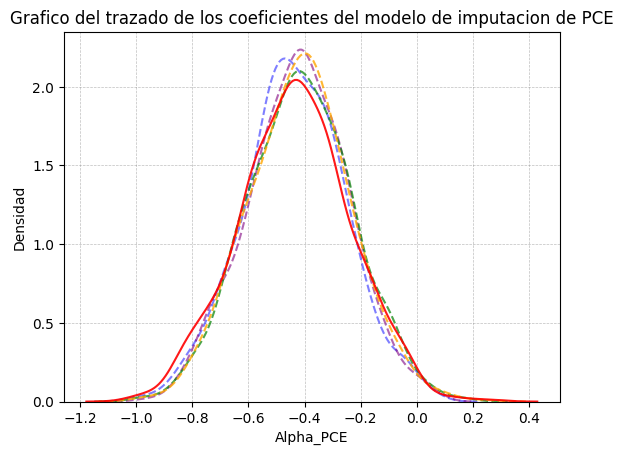

<Figure size 800x500 with 0 Axes>

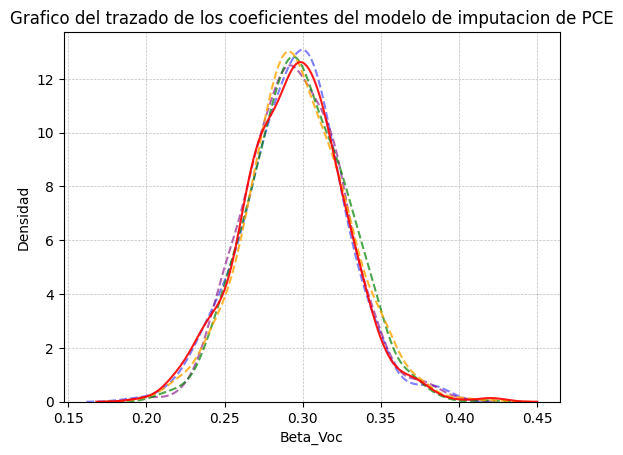

<Figure size 800x500 with 0 Axes>

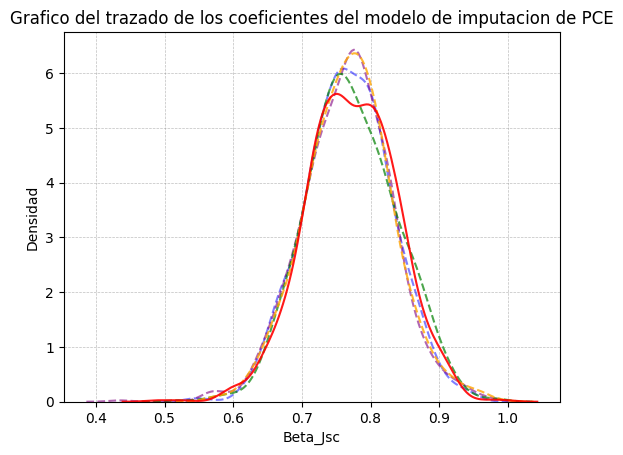

<Figure size 800x500 with 0 Axes>

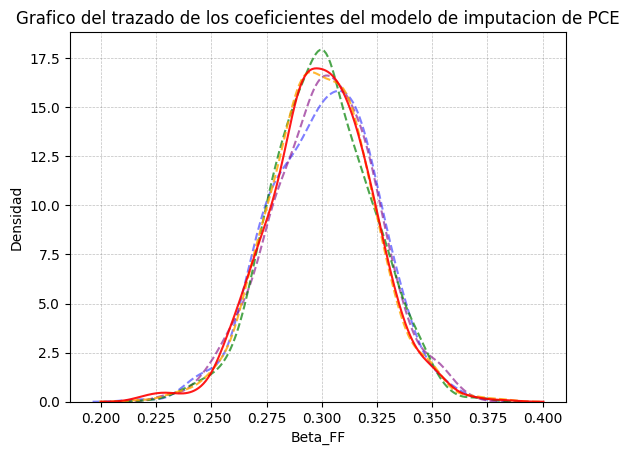

In [ ]:
names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness', "Alpha_PCE", "Voc", "Jsc", "FF"]
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
estilo_linea = ["--", "--", "--", "--", "-"]
transparencia = [0.5, 0.6, 0.7, 0.8, 0.9]
colores = ['b', 'purple', 'g', 'orange', 'r']
for datos in data[data.columns[8:9]]:
  for i in range(2,3):
    for name in names:
      plt.figure(figsize=(8, 5))
      fig, ax = plt.subplots()
      for j in range (0,5):
        sns.kdeplot(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name][j], linestyle=estilo_linea[j], alpha = transparencia[j], color = colores[j])
        plt.title(f"Grafico del trazado de los coeficientes del modelo de imputacion de {datos}")
        plt.ylabel("Densidad")
        if name == f"Alpha_{datos}":
          plt.xlabel(f"{name}")
        else:
          plt.xlabel(f"Beta_{name}")
        plt.grid(True, **grid_style)
        ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Imputacion/SAMPLEO/'
        plt.savefig(ruta + f'trazos_{datos}_{name}.png')
      plt.show()